<h6><b>실습을 위한 데이터셋 불러오기</b></h6>

In [43]:
!wget https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv -O spam.csv

--2020-11-25 07:40:34--  https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2020-11-25 07:40:34 (15.5 MB/s) - ‘spam.csv’ saved [503663/503663]



In [44]:
# 필요한 라이브러리를 불러옵니다.
import pandas as pd

# 학습용 데이터를 초기화합니다.
dataset = pd.read_csv('spam.csv', encoding='latin1')

In [45]:
dataset

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


<h6><b>데이터 전처리하기</b></h6>

In [46]:
# 사용되지 않는 시리즈(Series) 제거하기
dataset = dataset.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [47]:
dataset.rename(columns={'v1':'label'}, inplace=True)
dataset.rename(columns={'v2':'content'}, inplace=True)

dataset['label'] = dataset['label'].replace('ham', 0)
dataset['label'] = dataset['label'].replace('spam', 1)

In [48]:
dataset

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


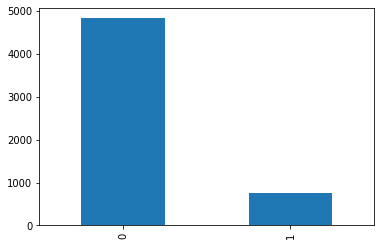

In [51]:
# 레이블을 값에 따라서 카운트를 한 뒤에 시각화
dataset['label'].value_counts().plot(kind='bar')

In [52]:
# 입력 데이터와 정답 데이터를 각각 초기화합니다.
X_data = dataset['content']
y_data = dataset['label']
print(len(X_data))
print(len(y_data))

5572
5572


In [53]:
# 토큰화를 수행하기 위해 라이브러리를 불러옵니다.
from tensorflow.keras.preprocessing.text import Tokenizer

# 각 문장에 대하여 토큰화를 수행합니다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
# 각 단어 시퀀스를 인덱스 형태로 변환하여 저장합니다.
sequences = tokenizer.texts_to_sequences(X_data)

In [54]:
# 토큰화 되어 데이터를 출력해 봅니다.
print(sequences[:5])

[[50, 469, 4410, 841, 751, 657, 64, 8, 1324, 89, 121, 349, 1325, 147, 2987, 1326, 67, 58, 4411, 144], [46, 336, 1495, 470, 6, 1929], [47, 486, 8, 19, 4, 796, 899, 2, 178, 1930, 1199, 658, 1931, 2320, 267, 2321, 71, 1930, 2, 1932, 2, 337, 486, 554, 955, 73, 388, 179, 659, 389, 2988], [6, 245, 152, 23, 379, 2989, 6, 140, 154, 57, 152], [1018, 1, 98, 107, 69, 487, 2, 956, 69, 1933, 218, 111, 471]]


In [55]:
# 각각의 단어들에 해당하는 인덱스를 찾습니다.
word_to_index = tokenizer.word_index
# print(word_to_index)
print("전체 단어의 개수:", len(word_to_index)) # 전체 단어 목록(Vocabulary)의 크기를 출력합니다.

전체 단어의 개수: 8920


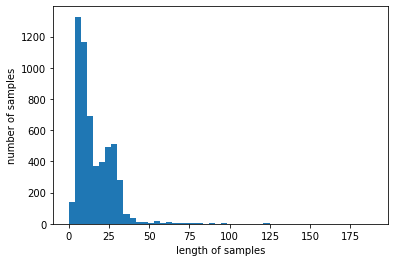

In [56]:
import matplotlib.pyplot as plt

# 입력 데이터로 변형된 단어 시퀀스를 넣습니다.
X_data = sequences

# 각 문자 메시지에 담긴 단어의 개수 통계를 확인합니다.
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<h6><b>RNN을 이용해 학습 진행하기</b></h6>

* 전체 데이터를 학습 데이터와 테스트 데이터로 나눕니다.


In [57]:
train_ratio = int(len(sequences) * 0.8)
test_ratio = int(len(sequences) - train_ratio)

In [58]:
# 학습 데이터의 개수
print(train_ratio)
# 테스트 데이터의 개수
print(test_ratio)

4457
1115


In [59]:
# 가장 많은 단어를 포함하고 있는 문장을 찾습니다.
max_length = 0
for words in X_data:
    max_length = max(max_length, len(words))

print(max_length)

189


In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 모든 데이터 셋의 크기는 가장 긴 데이터를 기준으로 맞춥니다. (길이: 189)
dataset = pad_sequences(X_data, maxlen=max_length)
print("훈련 데이터의 크기(shape): ", dataset.shape)

훈련 데이터의 크기(shape):  (5572, 189)


In [61]:
# 첫 번째 데이터는 어떻게 바뀌었을까요?
print(dataset[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   50  469 4410  841  751  657   64    8 1324   89  121  349 1325
  147 2987 1326   67   58 4411  144]


In [62]:
# 기존 데이터셋에서 뒷부분의 데이터를 테스트 데이터로 사용
X_test = dataset[train_ratio:]
y_test = np.array(y_data[train_ratio:])
# 기존 데이터셋에서 앞부분의 데이터를 학습 데이터로 사용
X_train = dataset[:train_ratio]
y_train = np.array(y_data[:train_ratio])

In [63]:
# RNN 아키텍처를 위한 라이브러리 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense

In [64]:
# 기본적으로 단어 인덱스가 0(패딩)부터 시작하므로, 전체 단어 사이즈에는 1을 더합니다.
voca_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((voca_size)))

단어 집합의 크기: 8921


In [67]:
# Hidden Size로 64를 설정합니다.
hidden_size = 64

# Keras를 이용해 전체 모델을 정의합니다.
model = Sequential()
model.add(Embedding(voca_size, hidden_size))
model.add(SimpleRNN(hidden_size))
model.add(Dense(1, activation='sigmoid'))

# 스팸/햄 구분이 목적이므로 Binary Cross Entropy Loss를 사용합니다. 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 오버피팅을 방지하기 위하여, Epoch를 5 정도만 돌립니다. (Early Stopping)
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
56/56 [==============================] - 7s 123ms/step - loss: 0.3429 - acc: 0.8755 - val_loss: 0.1525 - val_acc: 0.9451
Epoch 2/5
56/56 [==============================] - 7s 119ms/step - loss: 0.0919 - acc: 0.9767 - val_loss: 0.0886 - val_acc: 0.9697
Epoch 3/5
56/56 [==============================] - 7s 121ms/step - loss: 0.0392 - acc: 0.9896 - val_loss: 0.0760 - val_acc: 0.9776
Epoch 4/5
56/56 [==============================] - 7s 118ms/step - loss: 0.0224 - acc: 0.9935 - val_loss: 0.0620 - val_acc: 0.9809
Epoch 5/5
56/56 [==============================] - 7s 121ms/step - loss: 0.0107 - acc: 0.9969 - val_loss: 0.0612 - val_acc: 0.9854


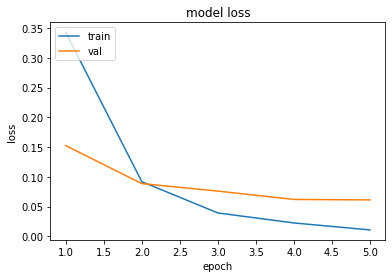

In [68]:
# 학습 결과를 시각화하여 출력합니다.
epochs = range(1, len(history.history['acc']) + 1)

# 학습이 잘 되었는지를 확인하기 위해 오버피팅 그래프를 그립니다.
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()